In [1]:
pwd

'/gpfs/space/home/pyvovar/repos/ADL-Minicar-Challenge-2023/mycar/notebooks'

In [8]:
!ls ../data/

steering  stop_sign  zebra_dataset


In [86]:
import os
import shutil
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.2.0


# Prepare Stop Sign Dataset

In [87]:
data_path = "../data"
data_path_steering = os.path.join(data_path, "steering")
data_path_stop_sign = os.path.join(data_path, "stop_sign")

In [175]:
os.makedirs(os.path.join(data_path, "stop_sign_dataset"), exist_ok=True)

In [176]:
ls ../data/

steering/  stop_sign/  stop_sign_dataset/  zebra_dataset/


In [177]:
ls ../data/steering

tub_3_22-10-25/  tub_5_22-10-27/  tub_7_22-11-01/
tub_4_22-10-25/  tub_6_22-11-01/  tub_8_22-11-03/


In [178]:
# Move images to directories that represent their classes
# NOTE: it is recommended to do this manually in CMD
without_src = [os.path.join(data_path_steering, d, "images") for d in os.listdir(data_path_steering)]
with_src = os.path.join(data_path_stop_sign, "tub_1_22-12-04", "images")

with_dst = os.path.join(data_path, "stop_sign_dataset", "with")
os.makedirs(with_dst, exist_ok=True)
without_dst = os.path.join(data_path, "stop_sign_dataset", "without")
os.makedirs(without_dst, exist_ok=True)

for dir_name in without_src:
    for img_name in os.listdir(dir_name):
        img_path = os.path.join(dir_name, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        shutil.copy(img_path, os.path.join(without_dst, img_name))
        
for img_name in os.listdir(with_src):
    img_path = os.path.join(with_src, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue
    shutil.copy(img_path, os.path.join(with_dst, img_name))

In [179]:
# Collected image paths and labels
label_without = 0
label_with = 1

# Collect paths of images WITHOUT a stop sign
images_without = [os.path.join(without_dst, img_name) for img_name in os.listdir(without_dst)]
images_without[:10]

['../data/stop_sign_dataset/without/4790_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/2488_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/14077_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/7364_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/317_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/13208_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/1844_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/18852_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/11363_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/16630_cam_image_array_.jpg']

In [180]:
ls {without_dst} | wc -l

20612


In [181]:
ls {with_dst} | wc -l

1324


In [182]:
len(images_without)

20612

In [183]:
random.seed(2022)
images_subsample = random.sample(images_without, k=10_000)

In [184]:
images_subsample[:10]

['../data/stop_sign_dataset/without/14196_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/13704_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/16968_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/1241_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/30_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/4035_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/19655_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/3478_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/16932_cam_image_array_.jpg',
 '../data/stop_sign_dataset/without/8412_cam_image_array_.jpg']

In [194]:
labels = [label_without] * len(images_subsample)

In [186]:
# Collect paths of images WITH a stop sign
images_with = [os.path.join(with_dst, img_name) for img_name in os.listdir(with_dst)]
images_with[:10]

['../data/stop_sign_dataset/with/317_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/253_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/55_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/281_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/818_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/992_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/289_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/674_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/1142_cam_image_array_.jpg',
 '../data/stop_sign_dataset/with/550_cam_image_array_.jpg']

In [195]:
labels += [label_with] * len(images_with)

# Prepare Input Data Pipeline

In [196]:
X_train, X_test, y_train, y_test = train_test_split(images_subsample + images_with, labels, test_size=0.1, shuffle=True, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=2022)

In [197]:
mean = [0.4251, 0.4787, 0.4311]  # calculated in the separate notebook
std = [0.2203, 0.2276, 0.2366]  # calculated in the separate notebook


def apply_normalization(cv_image_rgb_uint8):
    image = np.float32(cv_image_rgb_uint8) / 255.0
    image -= mean
    image /= std
    return image


def reverse_normalization(cv_image_rgb_float32):
    image = cv_image_rgb_float32 * std
    image += mean
    image *= 255
    image = image.astype(np.uint8)
    return image

In [198]:
def transforms(cv_image_rgb):
    return apply_normalization(cv_image_rgb)


def load_image(image_path):
    image_bgr = cv2.imread(image_path.numpy().decode("utf-8"))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = transforms(image_rgb)
    return tf.convert_to_tensor(image_rgb)


def preprocess_labels(label):
    return tf.expand_dims(tf.cast(label, "float32"), axis=-1)


def configure_dataset(ds):
    # Keep the images in memory after they're loaded off disk during the first epoch
    ds = ds.cache()
    # Drop elements that cause errors
    ds = ds.apply(tf.data.experimental.ignore_errors())
    # Wrap the 'load_image' call inside 'tf.py_function' due to https://github.com/tensorflow/tensorflow/issues/30653
    ds = ds.map(lambda image_path, label: (
        tf.py_function(load_image, [image_path], tf.float32),
        tf.py_function(preprocess_labels, [label], np.float32)
    ), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Create batches
    ds = ds.batch(64)
    # prepare later elements while the current element is being processed
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = configure_dataset(ds_train)
ds_val = configure_dataset(ds_val)
ds_test = configure_dataset(ds_test)

2022-12-04 19:02:45.306242: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(64, 120, 160, 3)
(64, 1)


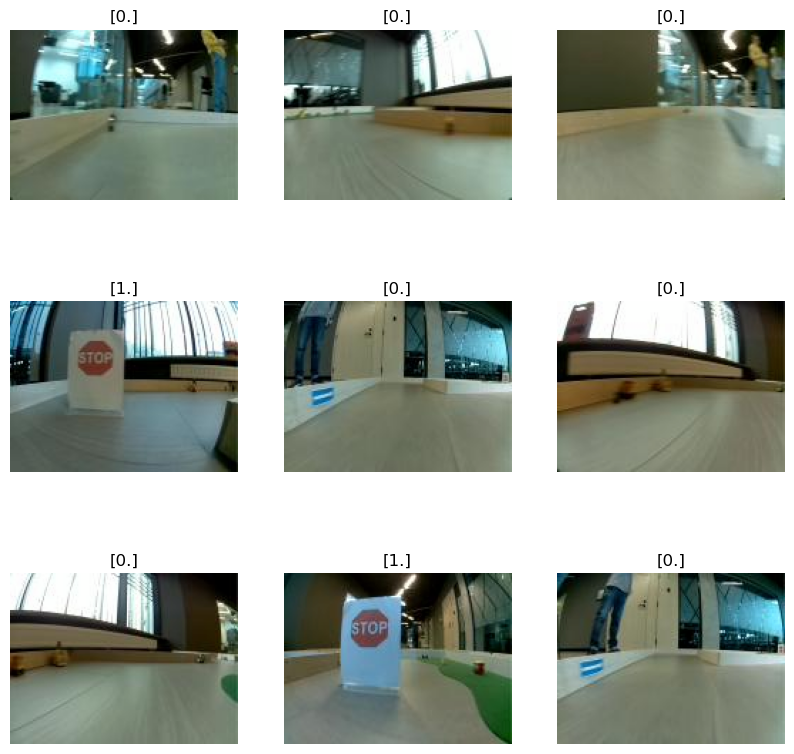

In [199]:
image_batch, label_batch = next(iter(ds_train))
print(image_batch.shape)
print(label_batch.shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(reverse_normalization(image_batch[-i].numpy()))
    # plt.imshow((image_batch[-i].numpy() * 255).astype(np.uint8))
    plt.title(label_batch[-i].numpy())
    plt.axis("off")

# Define and Train the Model

In [200]:
# TODO Cropping
# TODO Augmentation
# TODO add dropout and batch norm
# TODO K-Fold Cross-Validation for hyperparameters

model = tf.keras.Sequential([
    InputLayer(input_shape=(120, 160, 3)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

n_epochs = 5
log_frequency = 50
threshold = 0.5

optimizer = Adam(learning_rate=0.0001)
criterion = tf.keras.losses.BinaryCrossentropy()

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(n_epochs):
    # Training
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = model(image_batch, training=True)
            loss_value = criterion(label_batch, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        train_loss_history.append(current_loss)
        train_accuracy_history.append(current_accuracy)

        running_loss += current_loss
        running_accuracy += current_accuracy
        if (step + 1) % log_frequency == 0:
            print(
                f'Train [{epoch + 1}/{n_epochs}, {step + 1}/?]: Loss {running_loss / log_frequency}, Accuracy {running_accuracy / log_frequency}')
            running_loss = 0.0
            running_accuracy = 0.0

    # Validation
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_val):
        logits = model(image_batch, training=False)
        loss_value = criterion(label_batch, logits)

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        val_loss_history.append(current_loss)
        val_accuracy_history.append(current_accuracy)

        running_loss += current_loss
        running_accuracy += current_accuracy
        if (step + 1) % log_frequency == 0:
            print(
                f'Val [{epoch + 1}/{n_epochs}, {step + 1}/?]: Loss {running_loss / log_frequency}, Accuracy {running_accuracy / log_frequency}')
            running_loss = 0.0
            running_accuracy = 0.0

Train [1/5, 50/?]: Loss 0.31089306116104126, Accuracy 0.883125
Train [1/5, 100/?]: Loss 0.1542988108098507, Accuracy 0.945625
Train [2/5, 50/?]: Loss 0.07075194969773292, Accuracy 0.9825
Train [2/5, 100/?]: Loss 0.049865948855876925, Accuracy 0.98875
Train [3/5, 50/?]: Loss 0.025217190906405448, Accuracy 0.995
Train [3/5, 100/?]: Loss 0.01767088227905333, Accuracy 0.99625
Train [4/5, 50/?]: Loss 0.010590490016620607, Accuracy 0.99875
Train [4/5, 100/?]: Loss 0.007355995862744749, Accuracy 0.999375
Train [5/5, 50/?]: Loss 0.0059275368263479325, Accuracy 0.9996875
Train [5/5, 100/?]: Loss 0.003858464378863573, Accuracy 1.0


Text(0.5, 1.0, 'Accuracy')

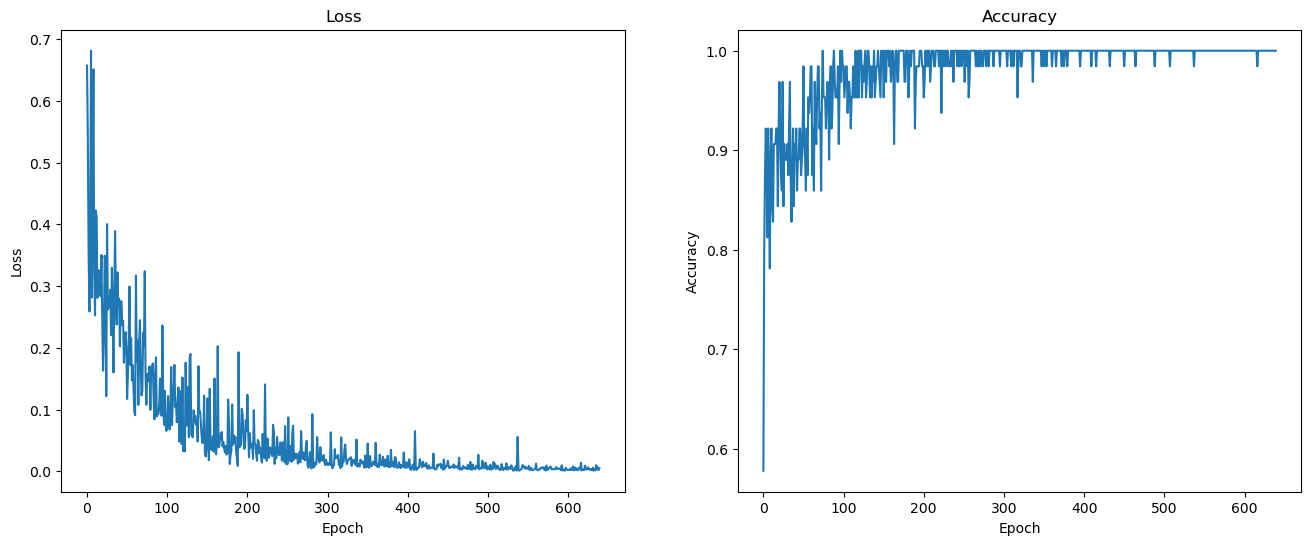

In [201]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
#plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history)
#plt.plot(val_accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [202]:
# TODO add confusion matrix and choose a threshold using AUC
# Testing
threshold = 0.5

test_loss = 0.0
test_accuracy = 0.0
batches = 0
for step, (image_batch, label_batch) in enumerate(ds_test):
    logits = model(image_batch, training=False)
    loss_value = criterion(label_batch, logits)

    # Metrics and Logging
    current_loss = loss_value.numpy()
    current_accuracy = accuracy_score(label_batch, logits > threshold)

    test_loss += current_loss
    test_accuracy += current_accuracy
    batches += 1

test_loss /= batches
test_accuracy /= batches

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.007707802313638644
Test Accuracy: 0.9987654320987654


In [203]:
model.save("stop_sign_detector")

2022-12-04 19:16:09.663373: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: stop_sign_detector/assets
